# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
!wget -nc http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv

File ‘Advertising.csv’ already there; not retrieving.



In [3]:
advertising = pd.read_csv('Advertising.csv', usecols=['TV','radio', 'newspaper','sales'])
advertising.info()
advertising.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
!wget -nc http://www-bcf.usc.edu/~gareth/ISL/Credit.csv

File ‘Credit.csv’ already there; not retrieving.



In [5]:

credit = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [6]:
!wget -nc http://www-bcf.usc.edu/~gareth/ISL/Auto.csv

File ‘Auto.csv’ already there; not retrieving.



In [7]:
auto = pd.read_csv('Auto.csv', na_values='?')
print('Total data: {}'.format(auto.size))
auto = auto.dropna()
print('Total data without null values: {}'.format(auto.size))
auto.head(1)

Total data: 3573
Total data without null values: 3528


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu


(-0.3999999999999999, 28.278724215528314)

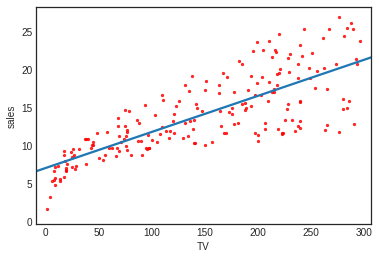

In [8]:
sns.regplot(advertising.TV, advertising.sales, order=1, ci=None, scatter_kws={'color':'r', 's':5})
plt.xlim(advertising.TV.min() - 10 ,advertising.TV.max() + 10)
plt.ylim(bottom=advertising.sales.min() - 2)

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [9]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)


14.0225
[0.04753664]


In [10]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

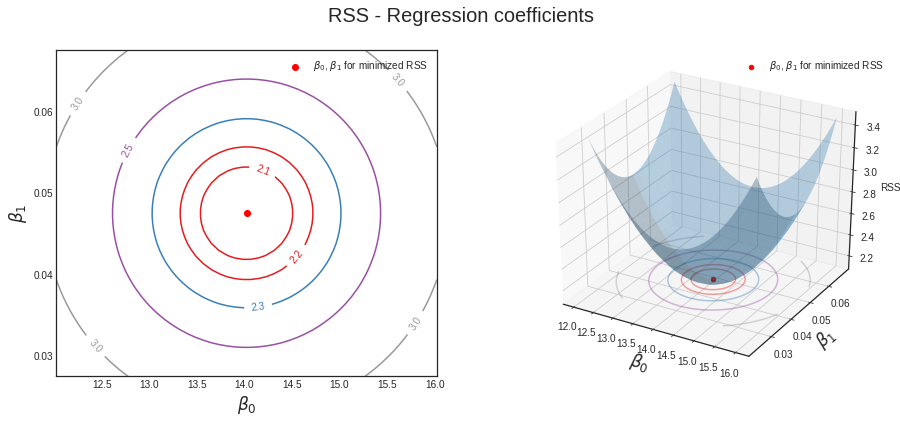

In [11]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [12]:
est = smf.ols('sales ~ TV', advertising).fit()
display(est.summary().tables[0])
est.summary().tables[1]

Dep. Variable:,sales,R-squared:,0.612
Model:,OLS,Adj. R-squared:,0.610
Method:,Least Squares,F-statistic:,312.1
Date:,"Thu, 10 Jan 2019",Prob (F-statistic):,1.47e-42
Time:,20:08:08,Log-Likelihood:,-519.05
No. Observations:,200,AIC:,1042.
Df Residuals:,198,BIC:,1049.
Df Model:,1,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [13]:
# RSS with regression coefficients 
((advertising.sales - (est.params[0] + est.params[1] * advertising.TV)) ** 2).sum()/1000

2.1025305831313514

### Table 3.1 & 3.2 - Scikit-learn

In [14]:
regr = skl_lm.LinearRegression()
X = advertising.TV.values.reshape(-1,1)
y = advertising.sales
regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)
Sales_pred = regr.predict(X)
print(r2_score(y, Sales_pred))
regr.score(X, y)

7.032593549127695
[0.04753664]
0.611875050850071


0.611875050850071

## Figure 3.3

100
100


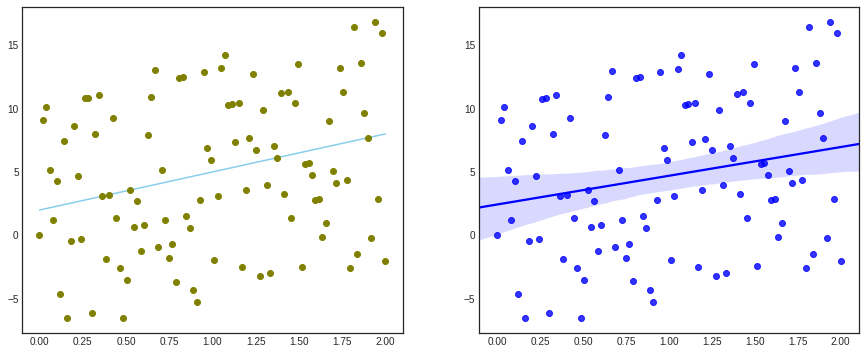

In [15]:
import random
xs = np.linspace(0, 2, 100)
errors = [random.randrange(-10, 10) for _ in range(100)]
xs_and_errors = list(zip(xs, errors))
ys = [2 + 3 * x + error for (x, error) in xs_and_errors] 
#sns.regplot(xs,ys)
true_values = np.array([2 + 3 * x  for (x, error) in xs_and_errors])
print(xs.size)
print(true_values.size)
true_matrix = np.column_stack((xs, true_values))
dots_matix = np.column_stack((xs, ys))

# multiple line plot
fig = plt.figure(figsize=(15,6))
                 
ax1 = fig.add_subplot(121)              
ax2 = fig.add_subplot(122)#, projection='3d')

ax1.plot( 'x', 'z', data=pd.DataFrame(true_matrix, columns=['x', 'z']), marker='', markerfacecolor='blue', markersize=12, color='skyblue')
ax1.plot( 'x', 'z', data=pd.DataFrame(dots_matix, columns=['x', 'z']),  marker='o', color='olive', linestyle='')
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
sns.regplot(xs, ys, color="blue", ci=95)
#plt.plot()
         

## 3.2 Multiple Linear Regression
### Table 3.3 - Statsmodels

In [16]:
est = smf.ols('sales ~ radio', advertising).fit()
display(est.summary().tables[0])
est.summary().tables[1]

Dep. Variable:,sales,R-squared:,0.332
Model:,OLS,Adj. R-squared:,0.329
Method:,Least Squares,F-statistic:,98.42
Date:,"Thu, 10 Jan 2019",Prob (F-statistic):,4.35e-19
Time:,20:08:10,Log-Likelihood:,-573.34
No. Observations:,200,AIC:,1151.
Df Residuals:,198,BIC:,1157.
Df Model:,1,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [17]:
est = smf.ols('sales ~ newspaper', advertising).fit()
display(est.summary().tables[0])
est.summary().tables[1]

Dep. Variable:,sales,R-squared:,0.052
Model:,OLS,Adj. R-squared:,0.047
Method:,Least Squares,F-statistic:,10.89
Date:,"Thu, 10 Jan 2019",Prob (F-statistic):,0.00115
Time:,20:08:10,Log-Likelihood:,-608.34
No. Observations:,200,AIC:,1221.
Df Residuals:,198,BIC:,1227.
Df Model:,1,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


### Table 3.4 & 3.6 - Statsmodels

In [18]:
est = smf.ols('sales ~ TV + radio + newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 10 Jan 2019   Prob (F-statistic):           1.58e-96
Time:                        20:08:10   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

In [19]:
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


### Figure 3.5 - Multiple Linear Regression

In [20]:
regr = skl_lm.LinearRegression()
X = advertising[['radio', 'TV']].values
y = advertising.sales
regr.fit(X, y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [25]:
#What are the min/max values of Radio & TV
#Use these values to set up the grid for plotting
advertising[['radio', 'TV']].describe()

,radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [31]:
#create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0, 300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = (regr.intercept_ + B1[i,j] * regr.coef_[0] + B2[i,j] * regr.coef_[1])

(0, 300)

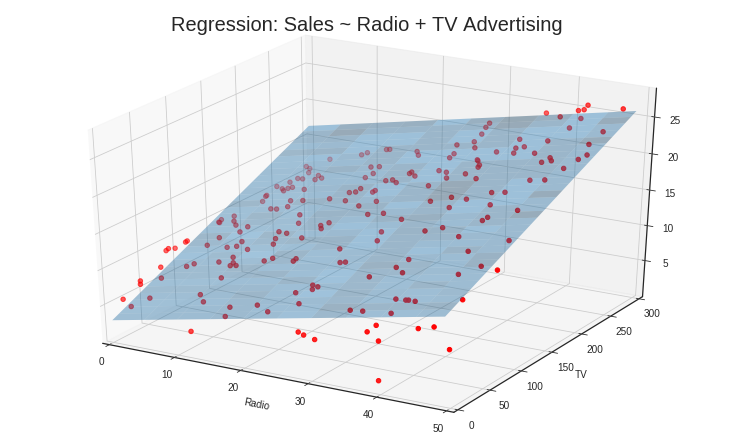

In [38]:
#create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)
ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.radio, advertising.TV, advertising.sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0, 50)
ax.set_ylabel('TV')
ax.set_ylim(0, 300)
ax.set_zlabel('Sales')